# Stock Price Prediction

### The stock price data represents the daily closing prices of multiple stocks over a specified time period. Each stock's price fluctuates based on various factors such as market demand, company performance, economic conditions, and investor sentiment. The dataset provides a snapshot of stock price movements, allowing analysts to observe trends, patterns, and potential relationships between different stocks over time.

In [7]:
!pip install xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [8]:

# Load the data
data = pd.read_csv("stock_data.csv")

data.head()

,Unnamed: 0,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
0,2020-01-01,101.764052,100.160928,99.494642,99.909756,101.761266
1,2020-01-02,102.171269,99.969968,98.682973,100.640755,102.528643
2,2020-01-03,103.171258,99.575237,98.182139,100.574847,101.887811
3,2020-01-04,105.483215,99.308641,97.149381,100.925017,101.490049
4,2020-01-05,107.453175,98.188428,99.575396,101.594411,101.604283


In [9]:
print(data.dtypes)

Unnamed: 0     object
Stock_1       float64
Stock_2       float64
Stock_3       float64
Stock_4       float64
Stock_5       float64
dtype: object


In [10]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  365 non-null    object 
 1   Stock_1     365 non-null    float64
 2   Stock_2     365 non-null    float64
 3   Stock_3     365 non-null    float64
 4   Stock_4     365 non-null    float64
 5   Stock_5     365 non-null    float64
dtypes: float64(5), object(1)
memory usage: 17.2+ KB
None


In [11]:
data.rename(columns = {'Unnamed: 0': 'date'}, inplace = True)

In [12]:
data.head()

,date,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
0,2020-01-01,101.764052,100.160928,99.494642,99.909756,101.761266
1,2020-01-02,102.171269,99.969968,98.682973,100.640755,102.528643
2,2020-01-03,103.171258,99.575237,98.182139,100.574847,101.887811
3,2020-01-04,105.483215,99.308641,97.149381,100.925017,101.490049
4,2020-01-05,107.453175,98.188428,99.575396,101.594411,101.604283


In [13]:
data.describe()

,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
count,365.000000,365.000000,365.000000,365.000000,365.000000
mean,107.772577,81.105216,94.519502,117.407560,106.866865
std,7.398296,11.435212,6.519213,6.778527,3.760968
min,91.474442,62.414219,81.111434,99.909756,99.833309
25%,101.603117,69.328263,89.788068,112.209912,103.927072
50%,107.421299,84.283525,94.495546,117.788079,106.411328
75%,113.741728,91.548859,99.919465,123.132365,109.178007
max,121.901773,100.160928,107.588373,129.911386,116.243803


In [14]:
data

,date,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
0,2020-01-01,101.764052,100.160928,99.494642,99.909756,101.761266
1,2020-01-02,102.171269,99.969968,98.682973,100.640755,102.528643
2,2020-01-03,103.171258,99.575237,98.182139,100.574847,101.887811
3,2020-01-04,105.483215,99.308641,97.149381,100.925017,101.490049
4,2020-01-05,107.453175,98.188428,99.575396,101.594411,101.604283
...,...,...,...,...,...,...
360,2020-12-26,92.684784,63.408103,98.288992,117.788079,102.995720
361,2020-12-27,92.688279,62.816639,98.061845,116.605106,102.718260
362,2020-12-28,93.551993,63.597651,96.454800,115.441164,103.566068
363,2020-12-29,93.870037,64.114492,95.747485,113.856107,103.257107


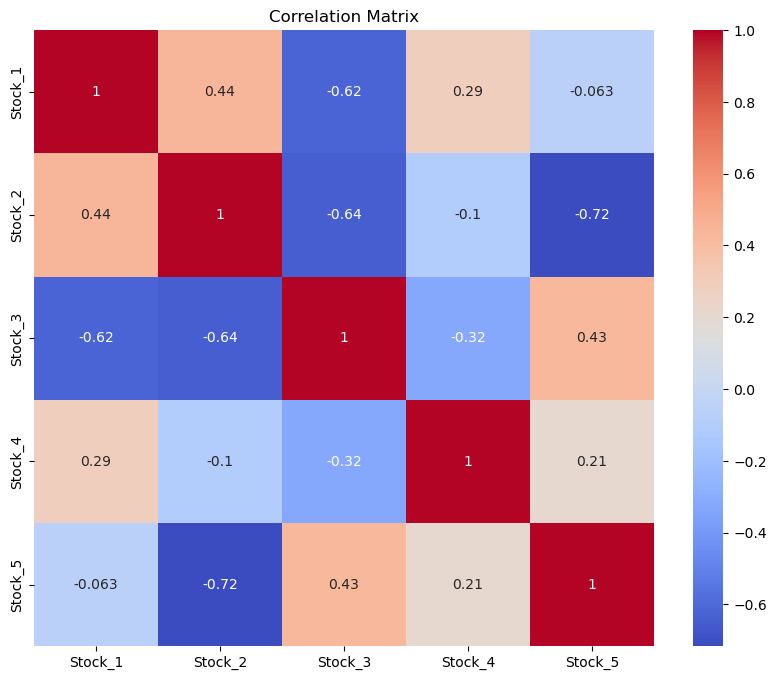

In [15]:
# Convert the date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Drop the date column for correlation calculation
data_for_corr = data.drop(columns=['date'])

# Calculate the correlation matrix
cormap = data_for_corr.corr()

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cormap, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Matrix')
plt.show()

In [17]:
def get_corelated_col(cor_dat, threshold): 
  feature=[]
  value=[]

  for i ,index in enumerate(cor_dat.index):
    if abs(cor_dat[index]) > threshold:
      feature.append(index)
      value.append(cor_dat[index])

  df = pd.DataFrame(data = value, index = feature, columns=['corr value'])
  return df

In [18]:
top_corelated_values = get_corelated_col(cormap['Stock_2'], 0.60)
top_corelated_values

,corr value
Stock_2,1.000000
Stock_3,-0.644440
Stock_5,-0.716303


In [20]:
data.shape

(365, 6)

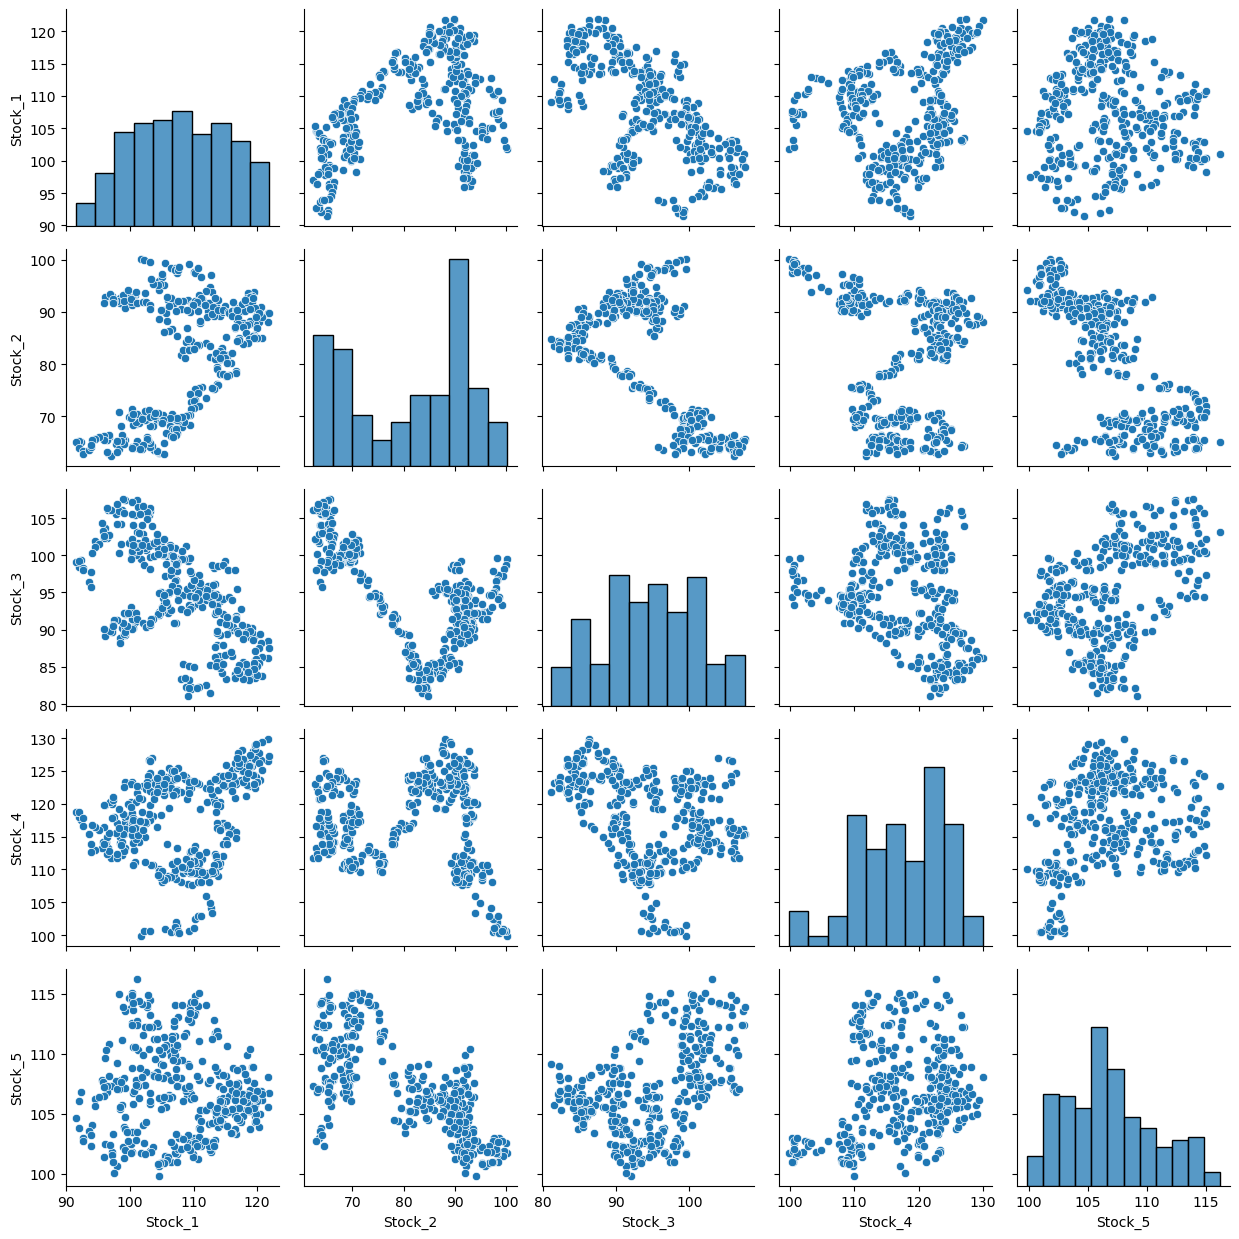

In [22]:
sns.pairplot(data)
plt.tight_layout()

In [25]:
X = data.drop(['Stock_2'], axis=1)
y = data['Stock_2']

In [26]:
X_numeric = X.select_dtypes(include=['number'])  # Select numeric columns only
# Scale the numeric features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)
X.head()

,date,Stock_1,Stock_3,Stock_4,Stock_5
0,2020-01-01,101.764052,99.494642,99.909756,101.761266
1,2020-01-02,102.171269,98.682973,100.640755,102.528643
2,2020-01-03,103.171258,98.182139,100.574847,101.887811
3,2020-01-04,105.483215,97.149381,100.925017,101.490049
4,2020-01-05,107.453175,99.575396,101.594411,101.604283


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, shuffle=True,random_state=42)

In [28]:
# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  
}

# Instantiate the KNN regressor
knn = KNeighborsRegressor()

# Instantiate the GridSearchCV object for KNN
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5)

# Fit the Grid Search object to your training data
grid_search_knn.fit(X_train, y_train)

# Use the best KNN estimator to make predictions
best_knn_model = grid_search_knn.best_estimator_
knn_predictions = best_knn_model.predict(X_test)

# Evaluate the KNN model performance using the evaluation metrics
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_rmse = knn_mse ** 0.5
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_r2 = r2_score(y_test, knn_predictions)

print("KNN Mean Squared Error:", knn_mse)
print("KNN Root Mean Squared Error:", knn_rmse)
print("KNN Mean Absolute Error:", knn_mae)
print("KNN R-squared Score:", knn_r2)

KNN Mean Squared Error: 1.220595206392523
KNN Root Mean Squared Error: 1.1048055061378554
KNN Mean Absolute Error: 0.8424122890306884
KNN R-squared Score: 0.9917297314021494


In [29]:
#!pip install xgboost
# XGBoost Regression Model with Grid Search
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}
xgb_model = GridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, cv=3, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_best_model = xgb_model.best_estimator_
xgb_predictions = xgb_best_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = xgb_mse ** 0.5
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print("\nXGBoost Regression Metrics:")
print("Mean Squared Error:", xgb_mse)
print("Root Mean Squared Error:", xgb_rmse)
print("Mean Absolute Error:", xgb_mae)
print("R-squared Score:", xgb_r2)


XGBoost Regression Metrics:
Mean Squared Error: 4.337831668818255
Root Mean Squared Error: 2.082746184444532
Mean Absolute Error: 1.5678623219139265
R-squared Score: 0.9706085745335519


In [30]:
# Random Forest Regression Model with Grid Search
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_model = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=3, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_best_model = rf_model.best_estimator_
rf_predictions = rf_best_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = rf_mse ** 0.5
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("\nRandom Forest Regression Metrics:")
print("Mean Squared Error:", rf_mse)
print("Root Mean Squared Error:", rf_rmse)
print("Mean Absolute Error:", rf_mae)
print("R-squared Score:", rf_r2)


Random Forest Regression Metrics:
Mean Squared Error: 5.919749600211485
Root Mean Squared Error: 2.4330535547355887
Mean Absolute Error: 1.4999082729743376
R-squared Score: 0.95989012657975


In [31]:
# Define the parameter grid for Grid Search
param_grid = {
    'fit_intercept': [True, False],
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid, cv=5)

# Fit the Grid Search object to your training data
grid_search.fit(X_train, y_train)
# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Evaluate the model performance using the evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

Mean Squared Error: 37.792663828406226
Root Mean Squared Error: 6.147573816425975
Mean Absolute Error: 5.172938242928456
R-squared Score: 0.7439319118637584
